# **Chapter 11**  
**┗ 코카콜라 주가 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「주가 Trend 파악하기」
* 🥈Session 2 - 「주가 이슈 파악하기」
* 🥇Session 3 - 「ML 활용 주가 예측」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter11')
# '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter11' ← 변경X
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter11'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** ⤴💸 (애널리스트, 리서치센터)

```
리서치센터 A는 주가의 상승, 하락에 대한 연구를 진행하고 있다. 시가, 고가, 저가, 종가 등 주가에 관련된 데이터와 거래량, 배당일,  
주식분할일 같은 추가 정보르 활용하여 주가 상승, 하강에 대해서 예측해보고자 한다.

```  

> **데이터 살펴보기**

* 코카콜라 주가 데이터
* 데이터 명세 ⬇  

|Date|Open|High|Low|Close|Volumne|Dividends|Stock Splits|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|날짜|시가|고가|저가|종가|거래량|배당일|분할일|

In [2]:
# ▶ Data read
import pandas as pd 
df = pd.read_csv('chapter11_stock.csv')
df.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0
5,1962-01-09,0.048728,0.049867,0.048349,0.049614,960000,0.0,0.0
6,1962-01-10,0.049614,0.050563,0.049108,0.049867,1612800,0.0,0.0
7,1962-01-11,0.049867,0.050374,0.049614,0.050374,614400,0.0,0.0
8,1962-01-12,0.050374,0.050374,0.049488,0.049994,883200,0.0,0.0
9,1962-01-15,0.049867,0.049867,0.049361,0.049488,614400,0.0,0.0



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 주가 상승, 하락에 대한 영향 요인 불분명 
```  

> **기대효과**

```
▶ 주가 상승, 하락에 대한 영향 요인 규명
```

> **해결방안**

```
▶ 주가 데이터 활용 모델링을 통한 상승, 하락 예측 및 영향 요인 탐색
▶ Session 1 🥉
 - 주식 데이터 Trend(추이) 그려보기
▶ Session 2 🥈
 - 주가 이슈, 거래량 이슈 등 특정 조건에 의한 일자 탐색, 이슈를 정의하고 변동일 탐색
▶ Session 3 🥇
 - ML 알고리즘을 활용하여 주가 상승/하락 예측
```

> **성과측정**  

```
▶ 추후 주가 예측에 대한 적중률
```

> **현업적용**  

```
▶ 장 종료시 모델에 주가 데이터 Input 후 상승/하락 예측
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → to_datetime, candlestick2_ohlc
▶ session 2 → np.where, value_counts(), shift()
▶ session 3 → train_test_split, classification_report, roc_auc_score, roc_curve
```

## **🥉Session 1**  
**┗ 주가 Trend 파악하기**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [3]:
# ▶ Data 형태 확인
# ▶ 15,122 row, 8 col로 구성됨
print('df', df.shape)

df (15122, 8)


In [4]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15122 entries, 0 to 15121
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          15122 non-null  object 
 1   Open          15122 non-null  float64
 2   High          15122 non-null  float64
 3   Low           15122 non-null  float64
 4   Close         15122 non-null  float64
 5   Volume        15122 non-null  int64  
 6   Dividends     15122 non-null  float64
 7   Stock Splits  15122 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 945.2+ KB


In [5]:
# ▶ Null 값 확인
print(df.isnull().sum())

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [6]:
# ▶ 시간 데이터 형변환
import datetime
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15122 entries, 0 to 15121
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          15122 non-null  datetime64[ns]
 1   Open          15122 non-null  float64       
 2   High          15122 non-null  float64       
 3   Low           15122 non-null  float64       
 4   Close         15122 non-null  float64       
 5   Volume        15122 non-null  int64         
 6   Dividends     15122 non-null  float64       
 7   Stock Splits  15122 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 945.2 KB


### · 주가 Trend Plotting
---

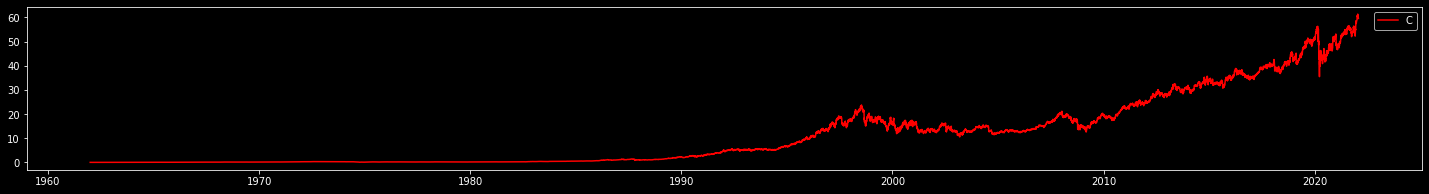

In [8]:
# ▶ 종가 확인
# ▶ 우상향 그래프
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

plt.plot(df['Date'], df['Close'], label='C', color='r');
plt.legend()
plt.gcf().set_size_inches(25, 3)

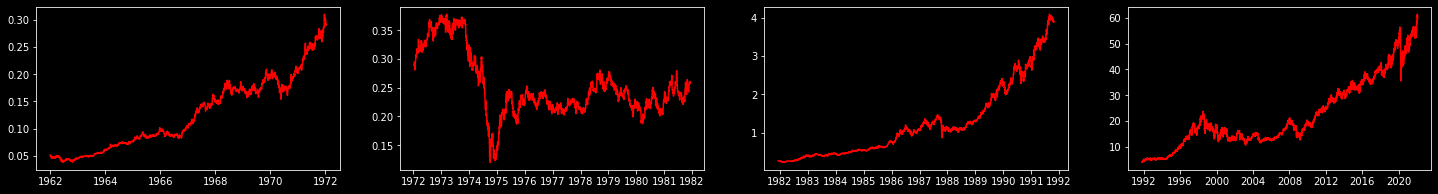

In [9]:
# ▶ 종가 확인
# ▶ 기간별 상세 주가 확인
plt.subplot(1,4,1)
plt.plot(df['Date'][0:2500], df['Close'][0:2500], label='C', color='r');

plt.subplot(1,4,2)
plt.plot(df['Date'][2501:5000], df['Close'][2501:5000], label='C', color='r');

plt.subplot(1,4,3)
plt.plot(df['Date'][5001:7500], df['Close'][5001:7500], label='C', color='r');

plt.subplot(1,4,4)
plt.plot(df['Date'][7501:], df['Close'][7501:], label='C', color='r');
plt.gcf().set_size_inches(25, 3)

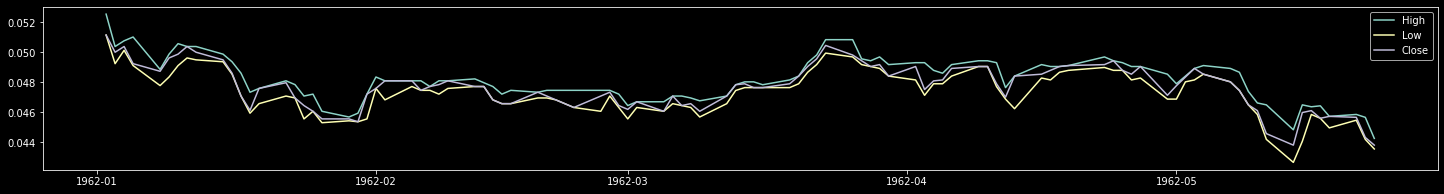

In [10]:
# ▶ High, Low, Close 그리기
plt.plot(df['Date'][0:100], df[['High', 'Low', 'Close']][0:100]);
plt.legend(['High', 'Low', 'Close'])
plt.gcf().set_size_inches(25, 3)

In [11]:
# ▶ package 설치법
!pip install mpl_finance

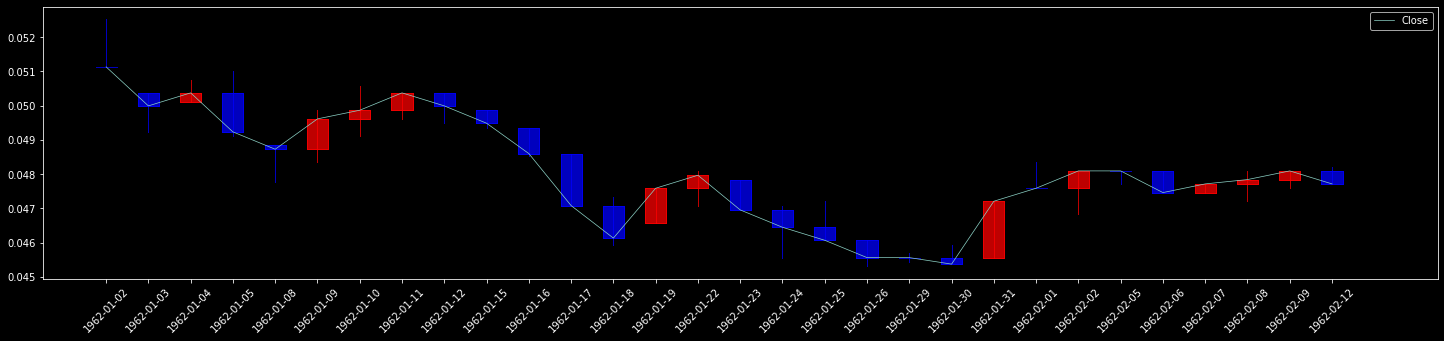

In [12]:
# ▶ 캔들스틱으로 주가 그래프 표현
from mpl_finance import candlestick2_ohlc

fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)

df_100 = df.iloc[0:30,:]
df_100 =df_100.set_index('Date')
index = df_100.index.astype('str')

ax.plot(index, df_100['Close'], label='Close', linewidth=0.7)

candlestick2_ohlc(ax, df_100['Open'], df_100['High'], 
                  df_100['Low'], df_100['Close'],
                  width=0.5, colorup='r', colordown='b');
plt.xticks(rotation=45)
ax.legend()

## **🥈Session 2**  
**┗ 주가 이슈 파악하기**  
---



### · 주가 이슈 정의 
---
* 거래량이 평균 대비 많이 발생한 날
* 전 거래일 종가(Colse) 대비 상승/하락한 날 


In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0


In [13]:
# ▶ 거래량 평균 2배 이상 발생했을 때를 기준 
import numpy as np
df['Volume_issue']  = np.where(df['Volume'] > 2*df['Volume'].mean(), 1, 0)
df['Volume_issue'].value_counts()

0    13490
1     1632
Name: Volume_issue, dtype: int64

In [14]:
1632/(13490+1632)

0.1079222325089274

In [15]:
# ▶ 상승률/하락률을 측정하기 위한 lag 함수
df['Close_lag'] = df['Close'].shift(1)
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,NaN
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0,0,0.050374
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0,0,0.049234


In [16]:
# ▶ NaN > 0
df = df.fillna(0.051133)
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,0.051133
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0,0,0.050374
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0,0,0.049234


In [17]:
# ▶ 전날 대비 상승률/하락률 산출
df['rate'] = ((df['Close'] - df['Close_lag']) / df['Close_lag'])*100
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag,rate
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,0.051133,0.000013
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133,-2.227947
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994,0.759800
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0,0,0.050374,-2.261532
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0,0,0.049234,-1.028203


In [18]:
# ▶ inf > 0, inf 경우 0을 대입
df['rate'] = df['rate'].replace([np.inf, -np.inf], 0)
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag,rate
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,0.051133,0.000013
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133,-2.227947
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994,0.759800
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0,0,0.050374,-2.261532
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0,0,0.049234,-1.028203


In [19]:
# ▶ 당일 기준 전날대비 5% 이상 변화시 Issue로 정의
df['rate_issue'] = np.where(abs(df['rate']) > 5, 1, 0)
df['rate_issue'].value_counts()

0    14986
1      136
Name: rate_issue, dtype: int64

In [20]:
df[ (df['Volume_issue'] == 1) & (df['rate_issue'] == 1) ]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag,rate,rate_issue
3180,1974-09-23,0.179116,0.179116,0.163540,0.163540,28022400,0.0,0.0,1,0.179116,-8.695637,1
5180,1982-08-23,0.282755,0.304506,0.281810,0.303560,20270400,0.0,0.0,1,0.282755,7.357888,1
5249,1982-11-30,0.366069,0.387488,0.366069,0.385541,23092800,0.0,0.0,1,0.364122,5.882386,1
5419,1983-08-02,0.373736,0.391724,0.373736,0.390725,30993600,0.0,0.0,1,0.370739,5.390769,1
5445,1983-09-08,0.394722,0.394722,0.383730,0.387727,55881600,0.0,0.0,1,0.415707,-6.730725,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14658,2020-03-26,40.508687,42.806449,40.139911,41.879780,37821700,0.0,0.0,1,39.345623,6.440759,1
14660,2020-03-30,40.697802,43.080666,40.697802,42.551140,23446000,0.0,0.0,1,40.480316,5.115631,1
14665,2020-04-06,42.919918,44.451758,42.258011,44.130260,22850000,0.0,0.0,1,41.444817,6.479565,1
14711,2020-06-11,45.208221,45.312232,42.986104,43.061752,26070400,0.0,0.0,1,45.974148,-6.334855,1


### · 거래량 이슈 일
---


In [21]:
# ▶ 거래량 이슈일 그래프로 표현하기 위해 색상 데이터 생성
df['vol_color'] = np.where(df['Volume_issue']==1, 'red', 'gray')
colors=list(df['vol_color'])
print(colors)

['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'red', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 

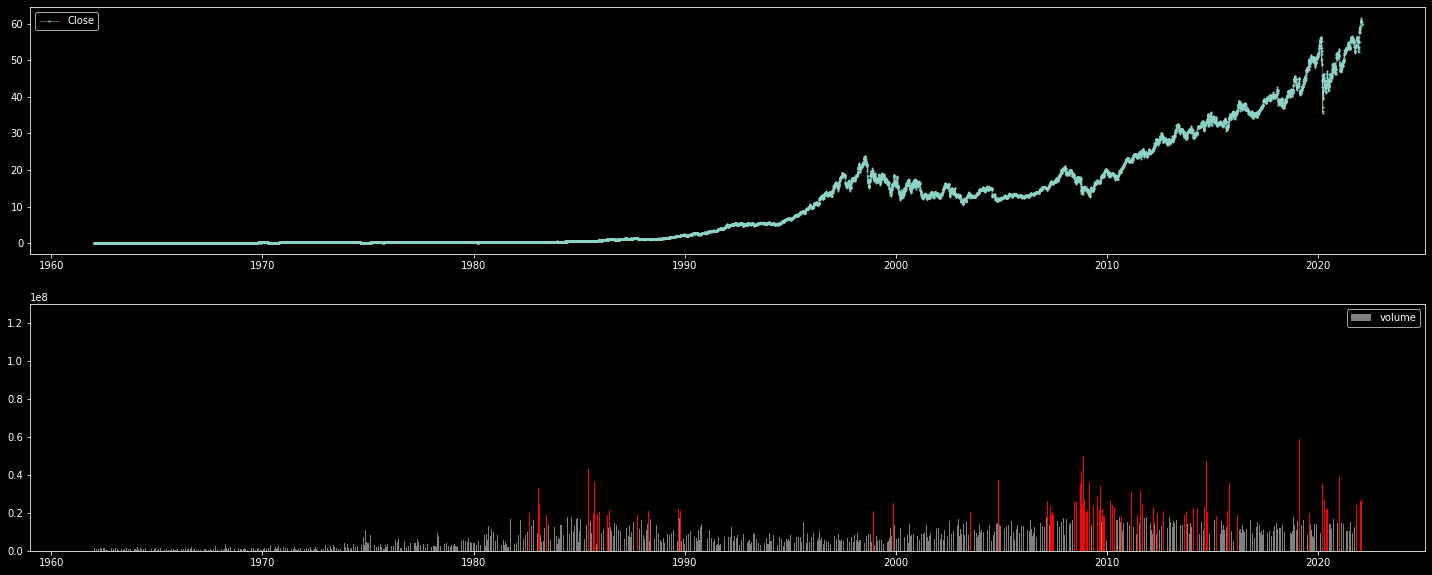

In [22]:
# ▶ 주가 Trend와 거래량 이슈 그래프 동시 표현 
plt.figure(figsize=(25, 10))

plt.subplot(2,1,1);
plt.plot(df['Date'], df['Close'], 'o-', ms=1, lw=0.5, label='Close');
plt.legend();


plt.subplot(2,1,2);
plt.bar(df['Date'], df['Volume'], label='volume', color=colors);
plt.legend();

### · 5%이상 주가 변동일
---


In [23]:
# ▶ 주가변동 이슈일 그래프로 표현하기 위해 색상 데이터 생성
df['rate_color'] = np.where(df['rate_issue']==1, 'red', 'gray')
colors_rate=list(df['rate_color'])
print(colors_rate)

['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'red', 'gray', 'gray', 'gray', 'red', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', '

In [24]:
df['rate_color'].value_counts()

gray    14986
red       136
Name: rate_color, dtype: int64

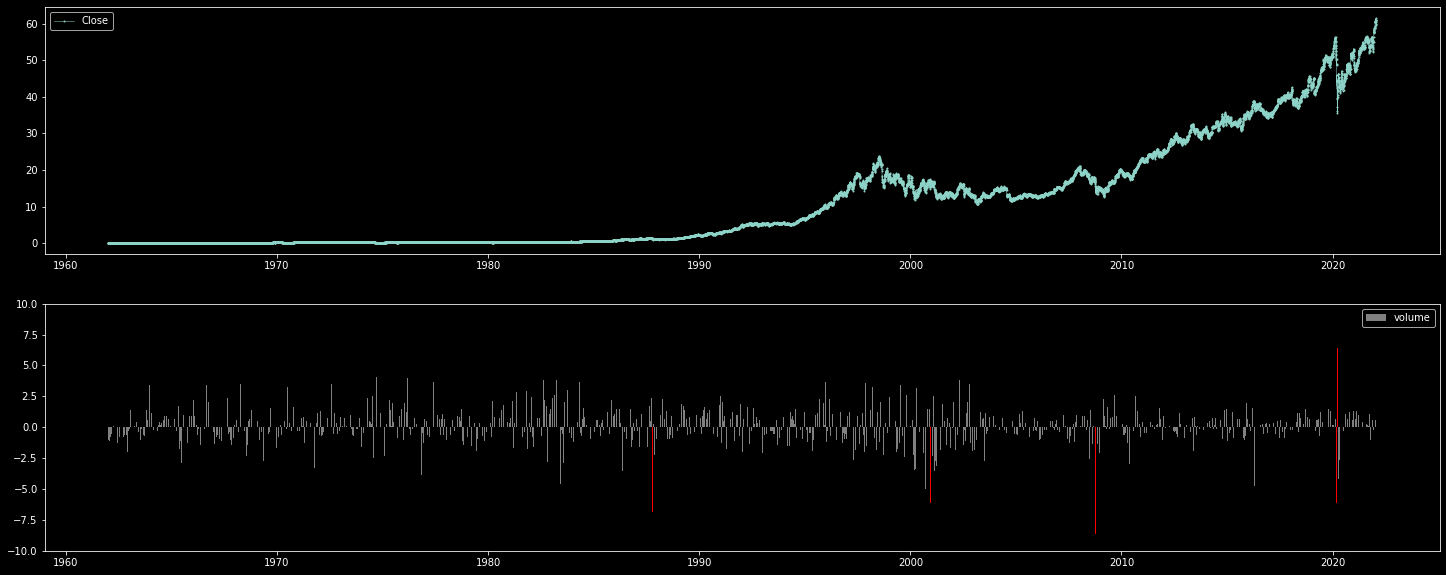

In [25]:
# ▶ 주가 Trend와 주가변동 이슈 그래프 동시 표현 
plt.figure(figsize=(25, 10))

plt.subplot(2,1,1)
plt.plot(df['Date'], df['Close'], 'o-', ms=1, lw=0.5, label='Close');
plt.legend();

plt.subplot(2,1,2);
plt.bar(df['Date'], df['rate'], label='volume',color=colors_rate);
plt.ylim(-10,10);
plt.legend();

## **🥇Session 3**  
**┗ ML 활용 주가 예측**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag,rate,rate_issue,vol_color,rate_color
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,0.051133,0.000013,0,gray,gray
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133,-2.227947,0,gray,gray
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994,0.759800,0,gray,gray
3,1962-01-05,0.050374,0.051006,0.049108,0.049234,1420800,0.0,0.0,0,0.050374,-2.261532,0,gray,gray
4,1962-01-08,0.048855,0.048855,0.047779,0.048728,2035200,0.0,0.0,0,0.049234,-1.028203,0,gray,gray


In [ ]:
# ▶ 사전 필요없는 col 제거
df.drop(['vol_color', 'rate_color'],axis=1, inplace=True)

In [ ]:
df.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag,rate,rate_issue
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,0.051133,0.000013,0
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133,-2.227947,0
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994,0.759800,0


In [ ]:
# ▶ 5% 이상은 Target률이 너무 적기 때문에 예측할 대상을 3% 기준으로 재설정
df['rate_issue'] = np.where(df['rate'] > 3, 1, 0)
df['rate_issue'].value_counts()

0    14727
1      395
Name: rate_issue, dtype: int64

In [ ]:
# ▶ 2.6% Target률 예측 문제
(395 / (395+14986)) * 100

2.568103504323516

In [ ]:
# ▶ 다음날 3% 초과의 변동이 있는 날을 예측하는 문제이기 때문에 shift(-1)을 적용하여 target 데이터를 생성
df['target'] =  df['rate_issue'].shift(-1)
df = df.fillna(0)
df[['Date', 'Close', 'rate', 'target']].iloc[1180:1190]

,Date,Close,rate,target
1180,1966-09-07,0.082183,-2.356980,0.0
1181,1966-09-08,0.082750,0.689594,0.0
1182,1966-09-09,0.083292,0.654997,1.0
1183,1966-09-12,0.087856,5.479592,0.0
1184,1966-09-13,0.087285,-0.649300,0.0
1185,1966-09-14,0.087285,0.000000,0.0
1186,1966-09-15,0.087856,0.653543,0.0
1187,1966-09-16,0.086429,-1.623512,0.0
1188,1966-09-19,0.087142,0.825001,0.0
1189,1966-09-20,0.086715,-0.490884,0.0


In [ ]:
df.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volume_issue,Close_lag,rate,rate_issue,target
0,1962-01-02,0.051133,0.052525,0.051133,0.051133,806400,0.0,0.0,0,0.051133,0.000013,0,0.0
1,1962-01-03,0.050374,0.050374,0.049234,0.049994,1574400,0.0,0.0,0,0.051133,-2.227947,0,0.0
2,1962-01-04,0.050121,0.050753,0.050121,0.050374,844800,0.0,0.0,0,0.049994,0.759800,0,0.0


In [ ]:
# ▶ 모델링을 학습하기 위한 Fearue(X)와 Y데이터를 구분하는 단계 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['Date','target'], axis=1)
Y=df['target']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(10585, 11)
(10585,)
(4537, 11)
(4537,)


### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
# ▶ 학습
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10309
         1.0       1.00      1.00      1.00       276

    accuracy                           1.00     10585
   macro avg       1.00      1.00      1.00     10585
weighted avg       1.00      1.00      1.00     10585

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      4418
         1.0       0.50      0.01      0.02       119

    accuracy                           0.97      4537
   macro avg       0.74      0.50      0.50      4537
weighted avg       0.96      0.97      0.96      4537



In [ ]:
pd.Series(y_pred_test).value_counts()

0.0    4535
1.0       2
dtype: int64

In [ ]:
# ▶ 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:,1]
y_pred_test_proba = rfc.predict_proba(x_test)[:,1]


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 1.0
roc_score_test : 0.6678570477534609


In [ ]:
from sklearn.metrics import roc_curve
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    # FPR : 암환자가 아닌 환자를 암환자라고 잘 못 예측한 비율
    # TPR : Recall
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random', color='red')
  
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

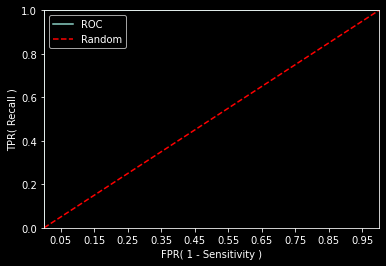

In [ ]:
roc_curve_plot(y_train, y_pred_train_proba)

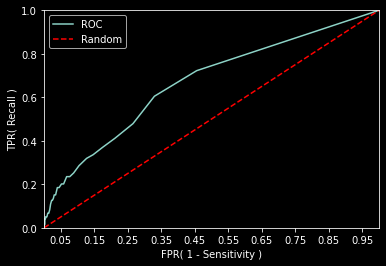

In [ ]:
roc_curve_plot(y_test, y_pred_test_proba)

### · Hyper paramter 튜닝
---
* 모델 성능을 올리기 위한 옵션 조절

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [400, 500],
           'max_depth' : [6, 8, 10, 12]
            }

# ▶ RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 123456, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1, scoring='recall')
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 8, 'n_estimators': 400}
최고 예측 정확도: 0.0036


In [ ]:
# ▶ Best score 기준 재학습
rfc = RandomForestClassifier(n_estimators=400, max_depth=4, random_state = 123456)
rfc.fit(x_train, y_train)

y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     10309
         1.0       1.00      0.01      0.01       276

    accuracy                           0.97     10585
   macro avg       0.99      0.50      0.50     10585
weighted avg       0.97      0.97      0.96     10585

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      4418
         1.0       0.00      0.00      0.00       119

    accuracy                           0.97      4537
   macro avg       0.49      0.50      0.49      4537
weighted avg       0.95      0.97      0.96      4537



In [ ]:
pd.Series(y_pred_test).value_counts()

0.0    4537
dtype: int64

In [ ]:
# ▶ threshold 조정 필요
y_pred_train = rfc.predict_proba(x_train)
y_pred_train = y_pred_train[:, 1]

for i in range(0,len(y_pred_train)):
    if y_pred_train[i]>=0.028:       # setting threshold to .5
       y_pred_train[i]=1
    else:  
       y_pred_train[i]=0

y_pred_test = rfc.predict_proba(x_test)
y_pred_test = y_pred_test[:, 1]
for i in range(0,len(y_pred_test)):
    if y_pred_test[i]>=0.028:       # setting threshold to .5
       y_pred_test[i]=1
    else:  
       y_pred_test[i]=0



print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93     10309
         1.0       0.10      0.47      0.17       276

    accuracy                           0.88     10585
   macro avg       0.54      0.68      0.55     10585
weighted avg       0.96      0.88      0.91     10585

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      4418
         1.0       0.07      0.29      0.11       119

    accuracy                           0.88      4537
   macro avg       0.52      0.59      0.52      4537
weighted avg       0.96      0.88      0.91      4537



In [ ]:
pd.Series(y_pred_test).value_counts()

0.0    4037
1.0     500
dtype: int64

In [ ]:
# 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:,1]
y_pred_test_proba = rfc.predict_proba(x_test)[:,1]


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.7719447338121608
roc_score_test : 0.6898412148924757


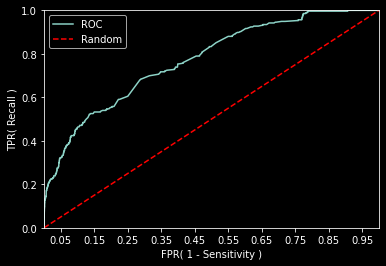

In [ ]:
roc_curve_plot(y_train, y_pred_train_proba)

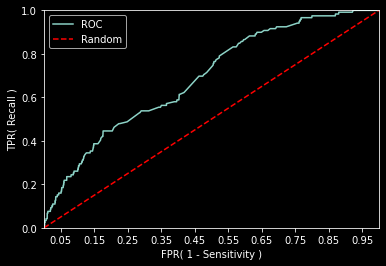

In [ ]:
roc_curve_plot(y_test, y_pred_test_proba)

### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

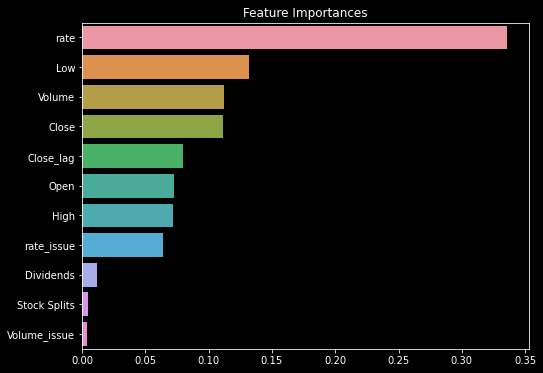

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:21]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

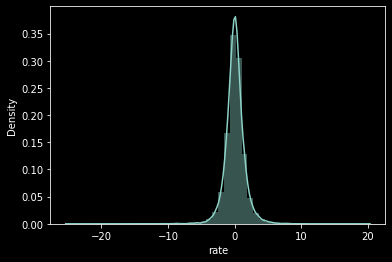

In [ ]:
# ▶ 중요변수 1번에 대한 상세 탐색
sns.distplot(df['rate']);

In [ ]:
# ▶ 구간화
import numpy as np
df['rate_gp'] = np.where (df['rate'] <= -5, 1, 
                           np.where(df['rate'] <= 5, 2, 3))

df[['rate','rate_gp']]

,rate,rate_gp
0,0.000013,2
1,-2.227947,2
2,0.759800,2
3,-2.261532,2
4,-1.028203,2
...,...,...
15117,-0.409836,2
15118,-0.493826,2
15119,-0.810590,2
15120,-0.233488,2


In [ ]:
df.groupby(['rate_gp', 'target'])['rate'].count()

rate_gp  target
1        0.0          44
         1.0          14
2        0.0       14616
         1.0         370
3        0.0          67
         1.0          11
Name: rate, dtype: int64

In [ ]:
# ▶ 전날 기준으로 종가가 하락했을 경우, 상승될 확률이 더 높음 (24%)
print("gp1 :", 14 / (14+44))
print("gp2 :", 370 / (370+14616))
print("gp3 :", 11 / (11+67))

gp1 : 0.2413793103448276
gp2 : 0.024689710396369944
gp3 : 0.14102564102564102


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)